# Installs & Imports

In [1]:
# Load the packages
library(MASS)
library(ggplot2)
library(dplyr)
library(GGally)
library(effects)
library(pscl)
library(boot)
library(caret)
library(reshape2)


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData

lattice theme set by effectsTheme()
See ?effectsTheme for details.

Classes and Methods for R originally developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University (2002-2015),
by and under the direction of Simon Jackman.
hurdle and zeroinfl functions by Achim Zeileis.

Loading required package: lattice


Attaching package: ‘lattice’


The following object is masked from ‘package:boot’:

    melanoma




# Loading & Exploring the Data

In [2]:
# Load the dataset
data("quine", package = "MASS")

In [3]:
# Basic structure
str(quine)

# Summary statistics
summary(quine)

# Frequency of the 'Days' variable
table(quine$Days)

'data.frame':	146 obs. of  5 variables:
 $ Eth : Factor w/ 2 levels "A","N": 1 1 1 1 1 1 1 1 1 1 ...
 $ Sex : Factor w/ 2 levels "F","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ Age : Factor w/ 4 levels "F0","F1","F2",..: 1 1 1 1 1 1 1 1 2 2 ...
 $ Lrn : Factor w/ 2 levels "AL","SL": 2 2 2 1 1 1 1 1 2 2 ...
 $ Days: int  2 11 14 5 5 13 20 22 6 6 ...


 Eth    Sex    Age     Lrn          Days      
 A:69   F:80   F0:27   AL:83   Min.   : 0.00  
 N:77   M:66   F1:46   SL:63   1st Qu.: 5.00  
               F2:40           Median :11.00  
               F3:33           Mean   :16.46  
                               3rd Qu.:22.75  
                               Max.   :81.00  


 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
 9  4  6  6  1 19  8  6  4  2  4  7  2  3  8  3  3  4  1  1  3  1  4  3  1  2 
27 28 30 32 33 34 36 37 38 40 41 43 45 46 47 48 53 54 57 60 67 69 81 
 2  2  2  2  1  1  3  1  1  2  1  1  1  1  1  1  2  1  1  1  1  1  1 

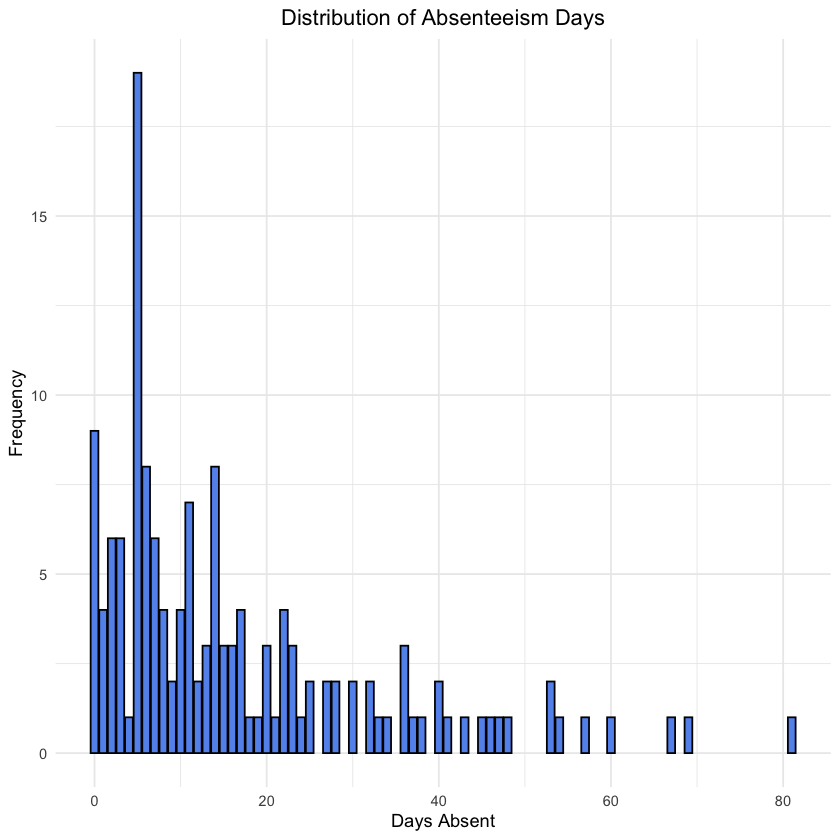

In [4]:
# Distribution of Days of Absenteeism
ggplot(quine, aes(x = Days)) + 
  geom_bar(fill = "cornflowerblue", color = "black") + 
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5)) +
  labs(title = "Distribution of Absenteeism Days", x = "Days Absent", y = "Frequency")

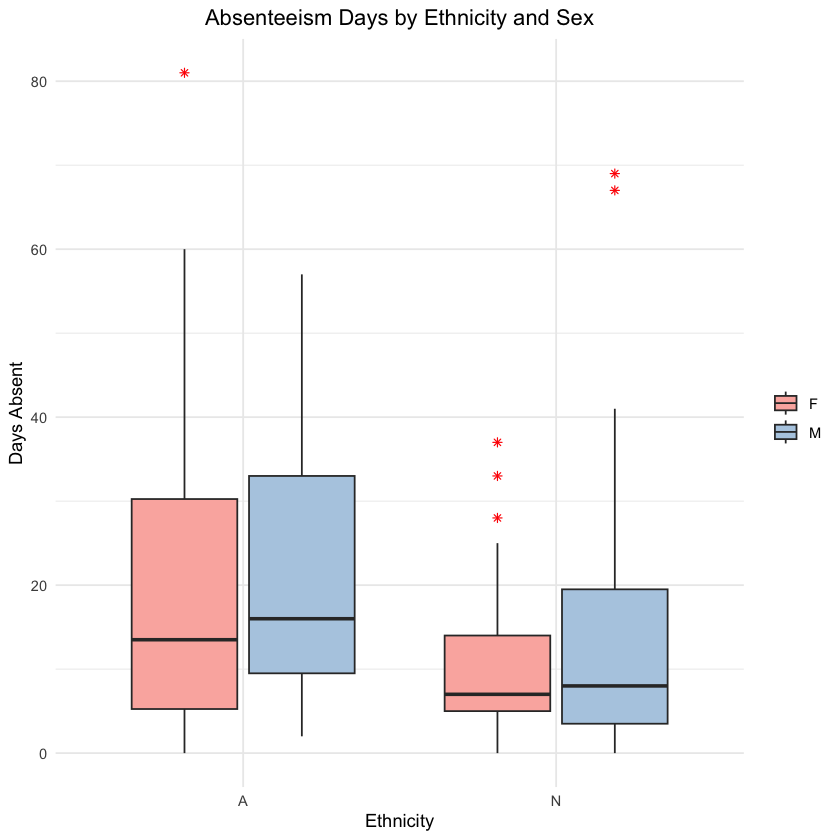

In [5]:
# Boxplots for Days Absent by Ethnicity and Sex
ggplot(quine, aes(x = Eth, y = Days, fill = Sex)) + 
  geom_boxplot(outlier.color = "red", outlier.shape = 8) + 
  scale_fill_brewer(palette = "Pastel1") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5), legend.title = element_blank()) +
  labs(title = "Absenteeism Days by Ethnicity and Sex", x = "Ethnicity", y = "Days Absent")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


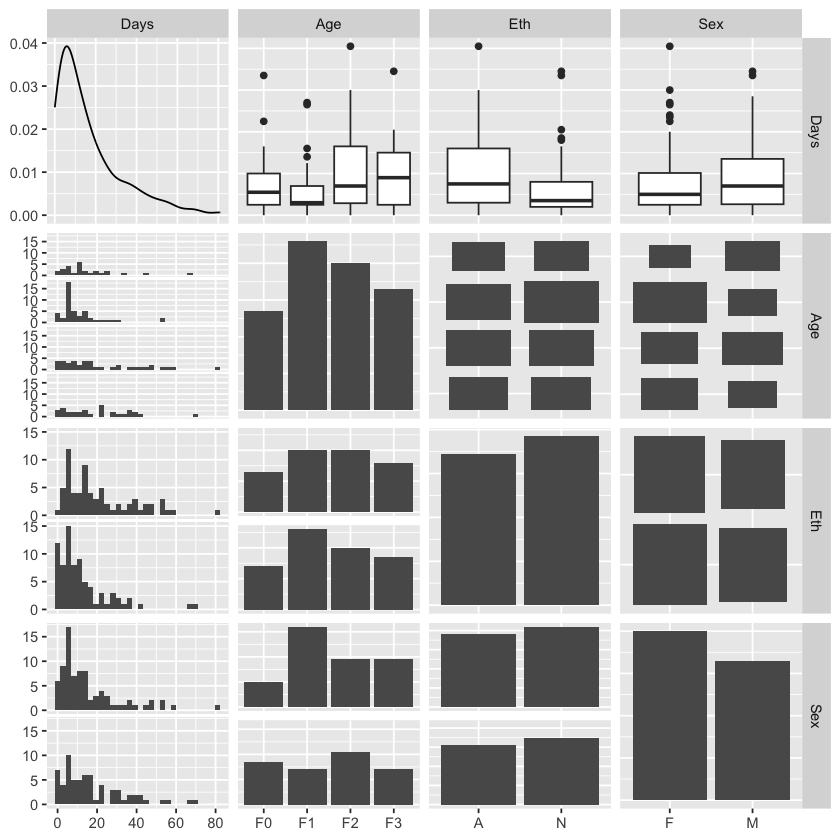

In [6]:
# Pairwise relationships
quine_selected <- quine %>% dplyr::select(Days, Age, Eth, Sex)
GGally::ggpairs(quine_selected)

In [7]:
# Grouped summary statistics
quine %>% 
  group_by(Eth, Sex) %>% 
  summarise(
    Avg_Days = mean(Days, na.rm = TRUE),
    Median_Days = median(Days, na.rm = TRUE),
    Min_Days = min(Days, na.rm = TRUE),
    Max_Days = max(Days, na.rm = TRUE)
  )

`summarise()` has grouped output by 'Eth'. You can override using the `.groups`
argument.


Eth,Sex,Avg_Days,Median_Days,Min_Days,Max_Days
<fct>,<fct>,<dbl>,<dbl>,<int>,<int>
A,F,20.92105,13.5,0,81
A,M,21.61290,16.0,2,57
N,F,10.07143,7.0,0,37
N,M,14.71429,8.0,0,69


In [8]:
# Check for missing values
sum(is.na(quine))

[1] 0

In [9]:
# Define predictor variables
predictors <- c("Sex", "Eth", "Age", "Lrn")

# Loop through predictors for Wilcoxon/Kruskal-Wallis tests
for(pred in predictors) {
  # Determine the number of levels in the factor
  num_levels <- length(levels(quine[[pred]]))
  
  # Apply Wilcoxon rank sum test if binary, Kruskal-Wallis otherwise
  if(num_levels == 2) {
    print(paste("Wilcoxon rank sum test for", pred, "vs Days:"))
    print(wilcox.test(Days ~ quine[[pred]], data = quine))
  } else {
    print(paste("Kruskal-Wallis test for", pred, "vs Days:"))
    print(kruskal.test(Days ~ quine[[pred]], data = quine))
  }
}

[1] "Wilcoxon rank sum test for Sex vs Days:"

	Wilcoxon rank sum test with continuity correction

data:  Days by quine[[pred]]
W = 2341, p-value = 0.2398
alternative hypothesis: true location shift is not equal to 0

[1] "Wilcoxon rank sum test for Eth vs Days:"

	Wilcoxon rank sum test with continuity correction

data:  Days by quine[[pred]]
W = 3602.5, p-value = 0.0002055
alternative hypothesis: true location shift is not equal to 0

[1] "Kruskal-Wallis test for Age vs Days:"

	Kruskal-Wallis rank sum test

data:  Days by quine[[pred]]
Kruskal-Wallis chi-squared = 7.6347, df = 3, p-value = 0.0542

[1] "Wilcoxon rank sum test for Lrn vs Days:"

	Wilcoxon rank sum test with continuity correction

data:  Days by quine[[pred]]
W = 2691, p-value = 0.7636
alternative hypothesis: true location shift is not equal to 0



In [10]:
# Loop through predictors for Chi-Square tests on all unique pairs
for(i in 1:(length(predictors) - 1)) {
  for(j in (i + 1):length(predictors)) {
    cat("\nChi-Square Test between", predictors[i], "and", predictors[j], ":\n")
    
    # Create contingency table for the pair of factors
    contingency_table <- with(quine, table(quine[[predictors[i]]], quine[[predictors[j]]]))
    
    # Perform the Chi-Square Test
    chi_square_result <- chisq.test(contingency_table)
    
    # Print the result
    print(chi_square_result)
  }
}


Chi-Square Test between Sex and Eth :

	Pearson's Chi-squared test with Yates' continuity correction

data:  contingency_table
X-squared = 0, df = 1, p-value = 1


Chi-Square Test between Sex and Age :

	Pearson's Chi-squared test

data:  contingency_table
X-squared = 8.4511, df = 3, p-value = 0.03755


Chi-Square Test between Sex and Lrn :

	Pearson's Chi-squared test with Yates' continuity correction

data:  contingency_table
X-squared = 2.7949, df = 1, p-value = 0.09456


Chi-Square Test between Eth and Age :

	Pearson's Chi-squared test

data:  contingency_table
X-squared = 0.41283, df = 3, p-value = 0.9376


Chi-Square Test between Eth and Lrn :

	Pearson's Chi-squared test with Yates' continuity correction

data:  contingency_table
X-squared = 0.0084084, df = 1, p-value = 0.9269


Chi-Square Test between Age and Lrn :

	Pearson's Chi-squared test

data:  contingency_table
X-squared = 42.708, df = 3, p-value = 2.838e-09



In [11]:
# Spearman's Rank Correlation Test
print("Spearman's correlation between Days and Age (treated as ordinal):")
print(cor.test(as.numeric(quine$Age), quine$Days, method = "spearman"))

[1] "Spearman's correlation between Days and Age (treated as ordinal):"


Warning message in cor.test.default(as.numeric(quine$Age), quine$Days, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  as.numeric(quine$Age) and quine$Days
S = 431511, p-value = 0.04262
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.168036 



# Descriptive Modeling

In [12]:
# Poisson model
poisson_model <- glm(Days ~ ., data = quine, family = poisson)
summary(poisson_model)


Call:
glm(formula = Days ~ ., family = poisson, data = quine)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.71538    0.06468  41.980  < 2e-16 ***
EthN        -0.53360    0.04188 -12.740  < 2e-16 ***
SexM         0.16160    0.04253   3.799 0.000145 ***
AgeF1       -0.33390    0.07009  -4.764 1.90e-06 ***
AgeF2        0.25783    0.06242   4.131 3.62e-05 ***
AgeF3        0.42769    0.06769   6.319 2.64e-10 ***
LrnSL        0.34894    0.05204   6.705 2.02e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2073.5  on 145  degrees of freedom
Residual deviance: 1696.7  on 139  degrees of freedom
AIC: 2299.2

Number of Fisher Scoring iterations: 5


In [13]:
# Negative binomial model
nb_model <- glm.nb(Days ~ ., data = quine)
summary(nb_model)


Call:
glm.nb(formula = Days ~ ., data = quine, init.theta = 1.274892646, 
    link = log)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.89458    0.22842  12.672  < 2e-16 ***
EthN        -0.56937    0.15333  -3.713 0.000205 ***
SexM         0.08232    0.15992   0.515 0.606710    
AgeF1       -0.44843    0.23975  -1.870 0.061425 .  
AgeF2        0.08808    0.23619   0.373 0.709211    
AgeF3        0.35690    0.24832   1.437 0.150651    
LrnSL        0.29211    0.18647   1.566 0.117236    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.2749) family taken to be 1)

    Null deviance: 195.29  on 145  degrees of freedom
Residual deviance: 167.95  on 139  degrees of freedom
AIC: 1109.2

Number of Fisher Scoring iterations: 1


              Theta:  1.275 
          Std. Err.:  0.161 

 2 x log-likelihood:  -1093.151 

In [14]:
# Zero-inflated negative binomial model
zinb_model <- zeroinfl(Days ~ . | ., data = quine, dist = "negbin")
summary(zinb_model)


Call:
zeroinfl(formula = Days ~ . | ., data = quine, dist = "negbin")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-1.1836 -0.7060 -0.2712  0.5118  3.5941 

Count model coefficients (negbin with log link):
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.88387    0.21756  13.256  < 2e-16 ***
EthN        -0.50956    0.14979  -3.402  0.00067 ***
SexM         0.16743    0.15760   1.062  0.28808    
AgeF1       -0.44161    0.22856  -1.932  0.05335 .  
AgeF2        0.05128    0.23216   0.221  0.82519    
AgeF3        0.30937    0.23604   1.311  0.18996    
LrnSL        0.28252    0.17544   1.610  0.10732    
Log(theta)   0.39640    0.13171   3.010  0.00262 ** 

Zero-inflation model coefficients (binomial with logit link):
            Estimate Std. Error z value Pr(>|z|)
(Intercept) -26.6848   484.4630  -0.055    0.956
EthN         13.7292   424.5594   0.032    0.974
SexM         11.7614   233.3545   0.050    0.960
AgeF1         0.1852     1.4154   0.131  

# Diagnostic Analysis

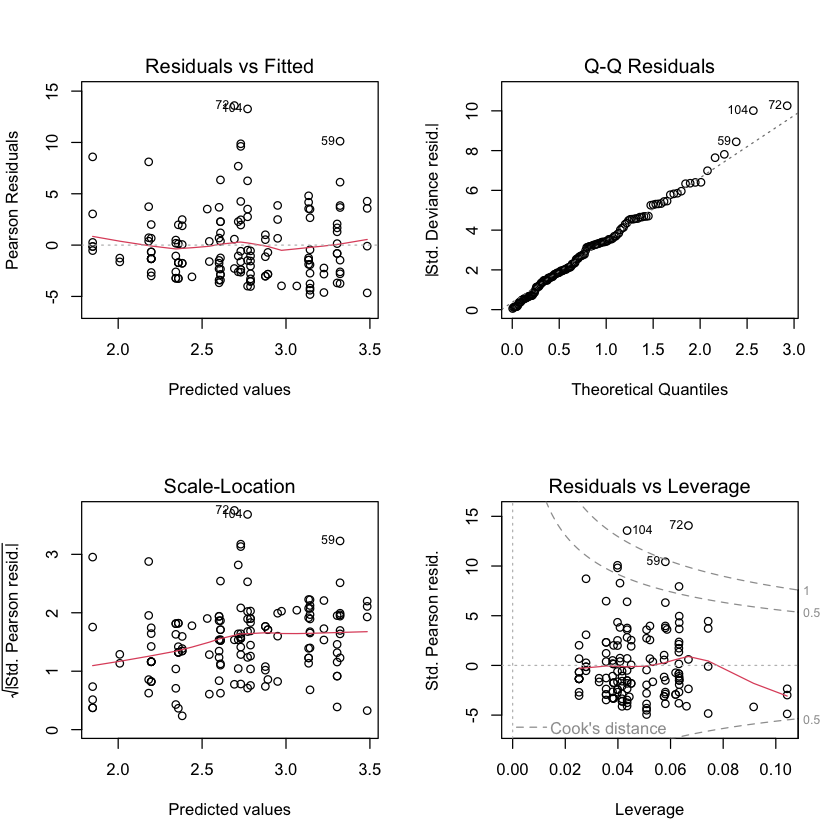

In [15]:
# Poisson diagnostic analysis
par(mfrow=c(2,2))
plot(poisson_model)

In [16]:
# Poisson model diagnostic for overdispersion
poisson_dev_resid <- sum(residuals(poisson_model, type = "pearson")^2)
poisson_overdispersion <- poisson_dev_resid / poisson_model$df.residual
print(paste("Poisson model overdispersion parameter:", poisson_overdispersion))

[1] "Poisson model overdispersion parameter: 13.1668426271774"


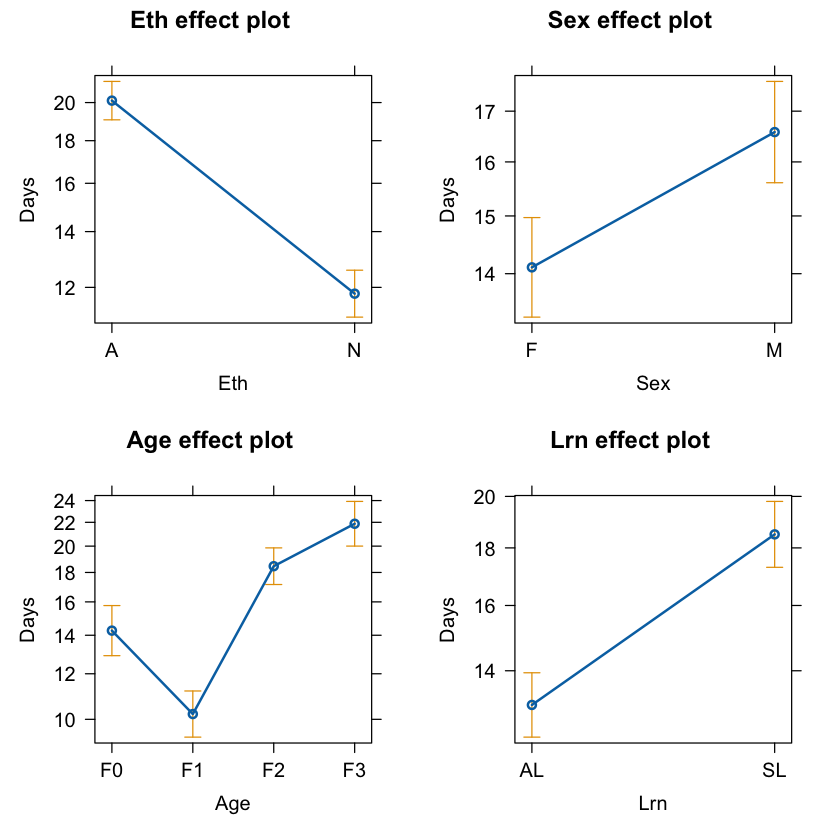

In [17]:
# Visualize effect of predictors
plot(allEffects(poisson_model))

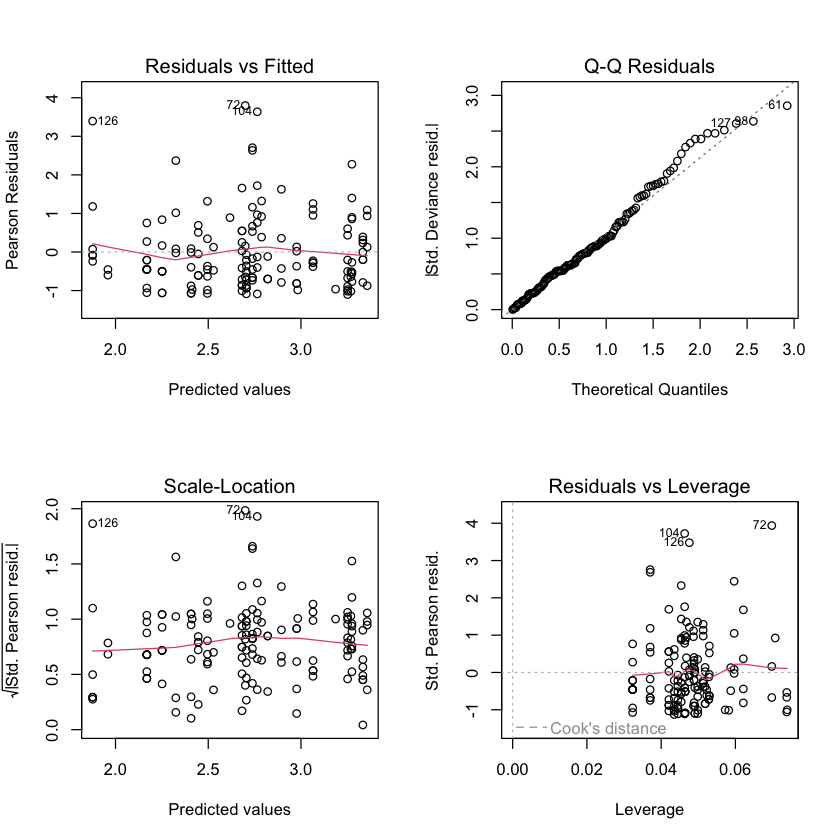

In [18]:
# Negative binomial diagnostic analysis
par(mfrow=c(2,2))
plot(nb_model)

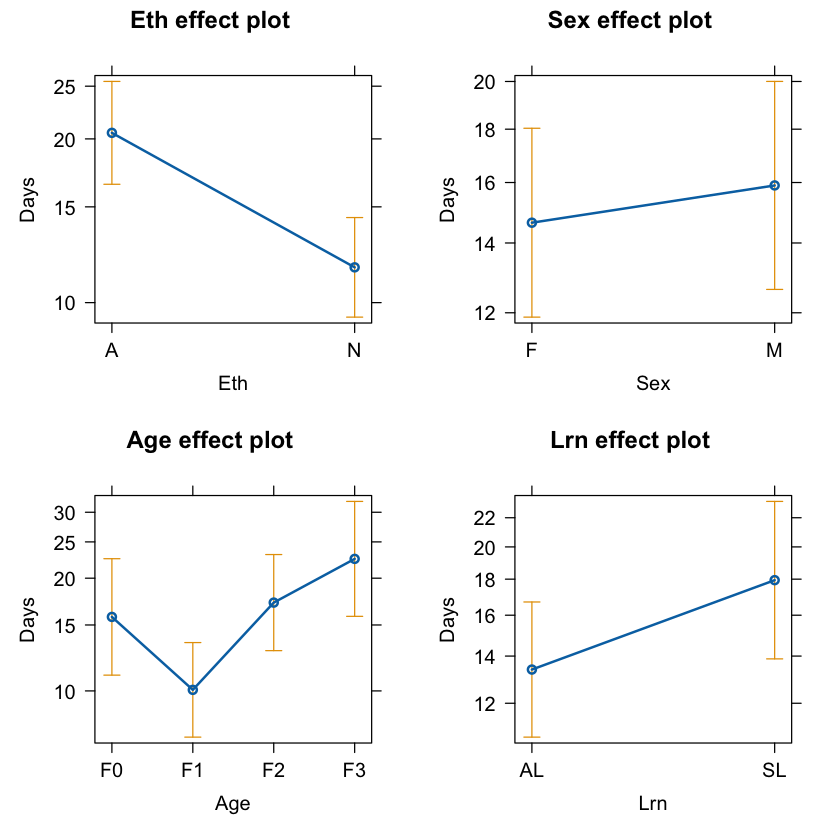

In [19]:
# Visualize effect of predictors
plot(allEffects(nb_model))

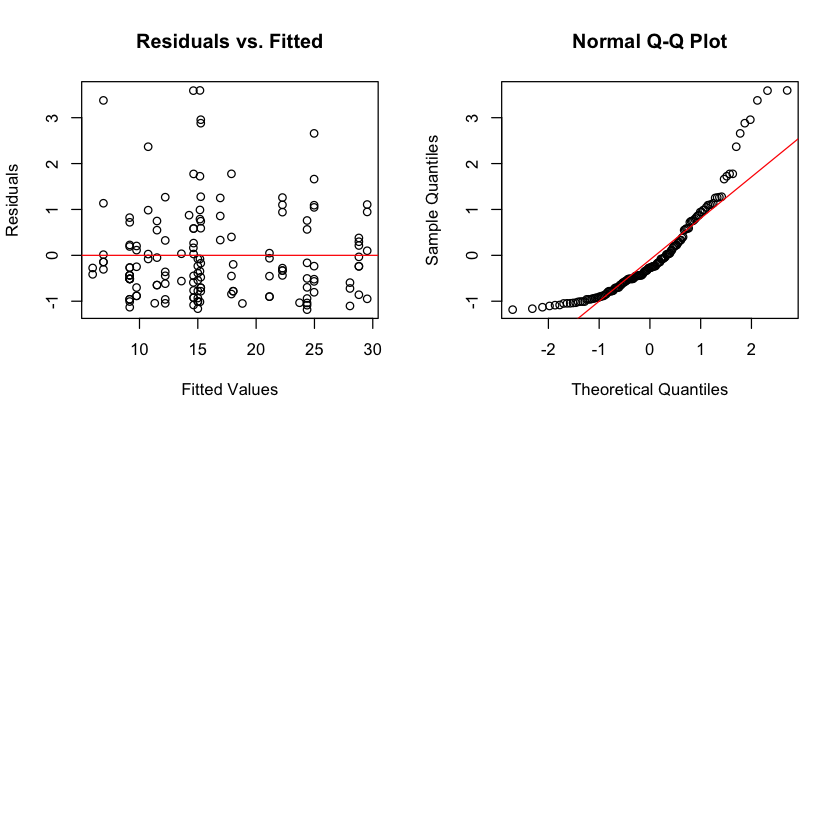

In [20]:
# Zero-inflated negative binomial diagnostic analysis
# Compute fitted values
fitted_values <- fitted(zinb_model)

# Compute residuals
residuals_values <- residuals(zinb_model, type = "pearson")

# Basic plot settings
par(mfrow = c(2, 2))

# Plot 1: Residuals vs. Fitted
plot(fitted_values, residuals_values,
     xlab = "Fitted Values",
     ylab = "Residuals",
     main = "Residuals vs. Fitted")
abline(h = 0, col = "red")

# Plot 2: Normal Q-Q Plot
qqnorm(residuals_values)
qqline(residuals_values, col = "red")

In [21]:
# AIC and BIC comparisons
AIC(poisson_model, nb_model, zinb_model)
BIC(poisson_model, nb_model, zinb_model)

,df,AIC
,<dbl>,<dbl>
poisson_model,7,2299.184
nb_model,8,1109.151
zinb_model,15,1114.118


,df,BIC
,<dbl>,<dbl>
poisson_model,7,2320.069
nb_model,8,1133.020
zinb_model,15,1158.873


# Predictive Modeling

In [22]:
# Set seed for reproducibility
set.seed(123)

# Split the data
train_indices <- sample(1:nrow(quine), 0.7 * nrow(quine))
train_data <- quine[train_indices, ]
test_data <- quine[-train_indices, ]

In [23]:
# Predictions on the test set
poisson_preds <- predict(poisson_model, newdata = test_data, type = "response")
nb_preds <- predict(nb_model, newdata = test_data, type = "response")
zinb_preds <- predict(zinb_model, newdata = test_data, type = "response")

In [24]:
# Function to calculate evaluation metrics
calculate_metrics <- function(actual, predicted) {
  mae <- mean(abs(actual - predicted))
  rmse <- sqrt(mean((actual - predicted)^2))
  mpd <- mean((actual - predicted)^2 / predicted) # Mean Poisson Deviance
  return(list(MAE = mae, RMSE = rmse, MPD = mpd))
}

In [25]:
# Evaluate the models
poisson_metrics <- calculate_metrics(test_data$Days, poisson_preds)
nb_metrics <- calculate_metrics(test_data$Days, nb_preds)
zinb_metrics <- calculate_metrics(test_data$Days, zinb_preds)

In [26]:
# Print out the metrics
print("Poisson Model Metrics:")
print(poisson_metrics)
print("Negative Binomial Model Metrics:")
print(nb_metrics)
print("Zero-Inflated Negative Binomial Model Metrics:")
print(zinb_metrics)

[1] "Poisson Model Metrics:"
$MAE
[1] 12.47739

$RMSE
[1] 16.74874

$MPD
[1] 14.3301

[1] "Negative Binomial Model Metrics:"
$MAE
[1] 12.77081

$RMSE
[1] 17.24965

$MPD
[1] 14.73345

[1] "Zero-Inflated Negative Binomial Model Metrics:"
$MAE
[1] 12.86912

$RMSE
[1] 17.4051

$MPD
[1] 15.2274



In [27]:
# Function to compare actual vs. predicted counts with visualization
plot_actual_vs_predicted <- function(actual, predicted, model_name) {
  ggplot(data = NULL, aes(x = actual, y = predicted)) +
    geom_point(color = "blue", alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
    labs(x = "Actual Days", y = "Predicted Days", title = paste(model_name, ": Actual vs Predicted")) +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5))
}

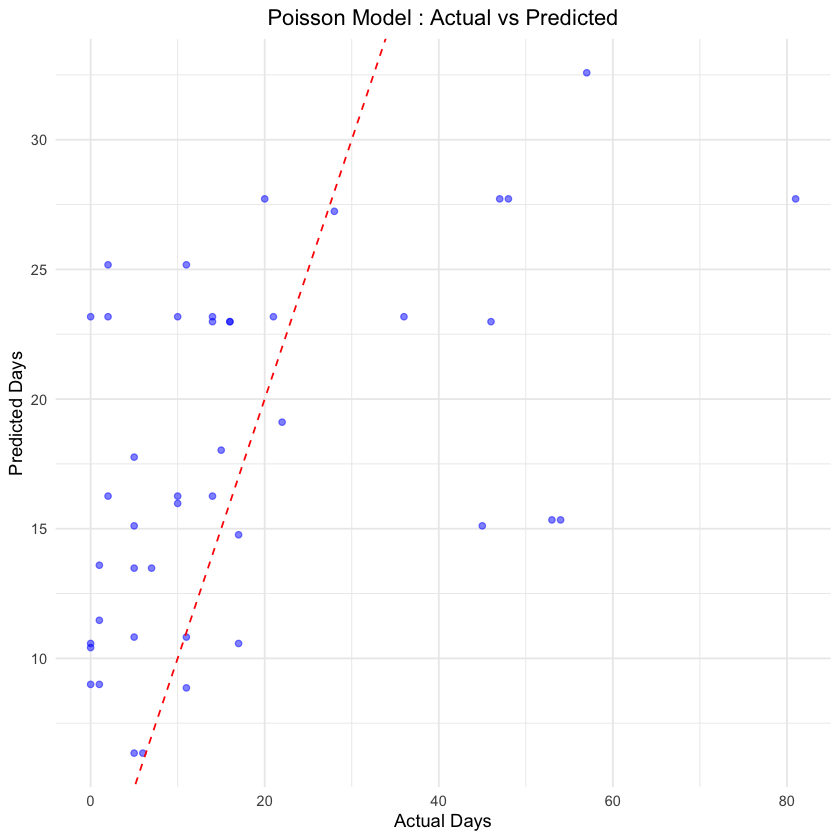

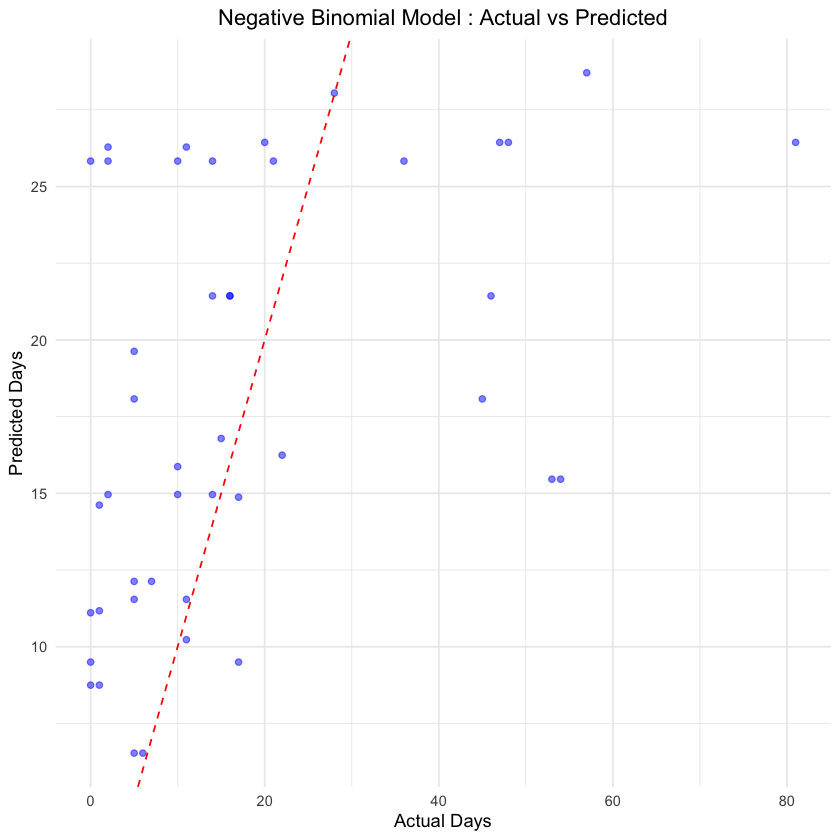

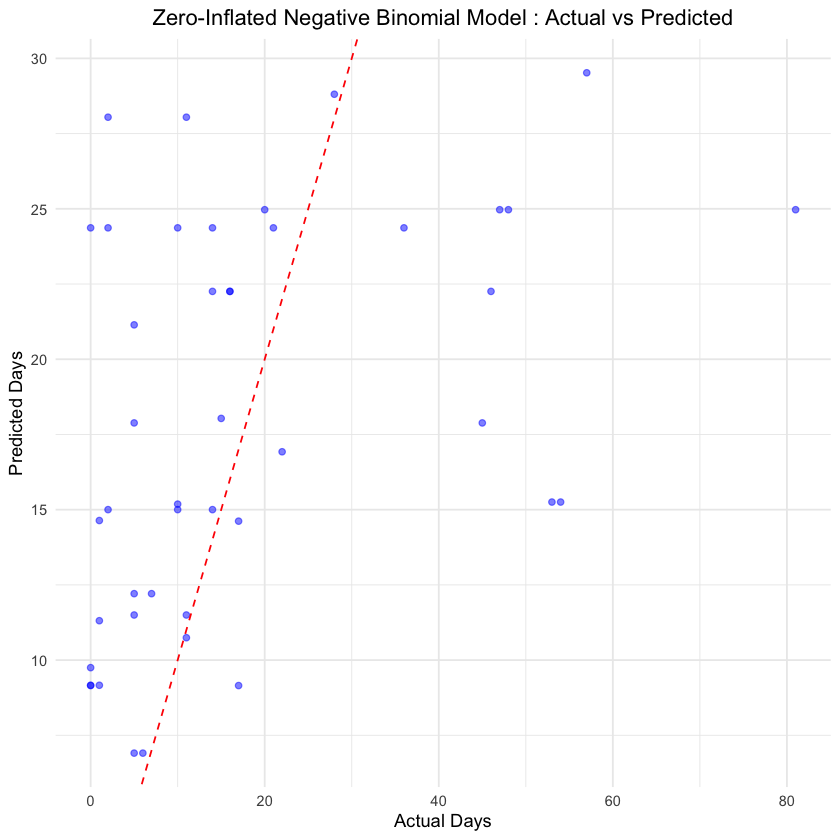

In [28]:
# Plot for each model
plot_actual_vs_predicted(test_data$Days, poisson_preds, "Poisson Model")
plot_actual_vs_predicted(test_data$Days, nb_preds, "Negative Binomial Model")
plot_actual_vs_predicted(test_data$Days, zinb_preds, "Zero-Inflated Negative Binomial Model")

In [29]:
# Function to predict and plot with confidence intervals
predict_and_plot <- function(model, test_data, model_type = "poisson") {
  # Check if the model type is either Poisson or Negative Binomial
  if (model_type %in% c("poisson", "nb")) {
    # Generate predictions with standard errors
    preds <- predict(model, newdata = test_data, type = "response", se.fit = TRUE)
    fit <- preds$fit
    se.fit <- preds$se.fit

    # Calculate confidence intervals
    upper_bound <- fit + 1.96 * se.fit
    lower_bound <- fit - 1.96 * se.fit

    # Create a data frame for plotting
    predictions_df <- data.frame(
      Actual = test_data$Days,
      Predicted = fit,
      LowerCI = lower_bound,
      UpperCI = upper_bound
    )

    # Plot with confidence intervals
    p <- ggplot(predictions_df, aes(x = Actual, y = Predicted)) +
      geom_point(color = "blue", alpha = 0.5) +
      geom_errorbar(aes(ymin = LowerCI, ymax = UpperCI), width = 0.1, color = "red", alpha = 0.5) +
      geom_abline(intercept = 0, slope = 1, linetype = "dotted", color = "darkgray") +
      labs(title = paste(model_type, "Model: Actual vs Predicted Counts with 95% CI"),
           x = "Actual Days", y = "Predicted Days") +
      theme_minimal()

    return(p)
  } else {
    stop("Unsupported model type: Only Poisson and NB models are supported.")
  }
}

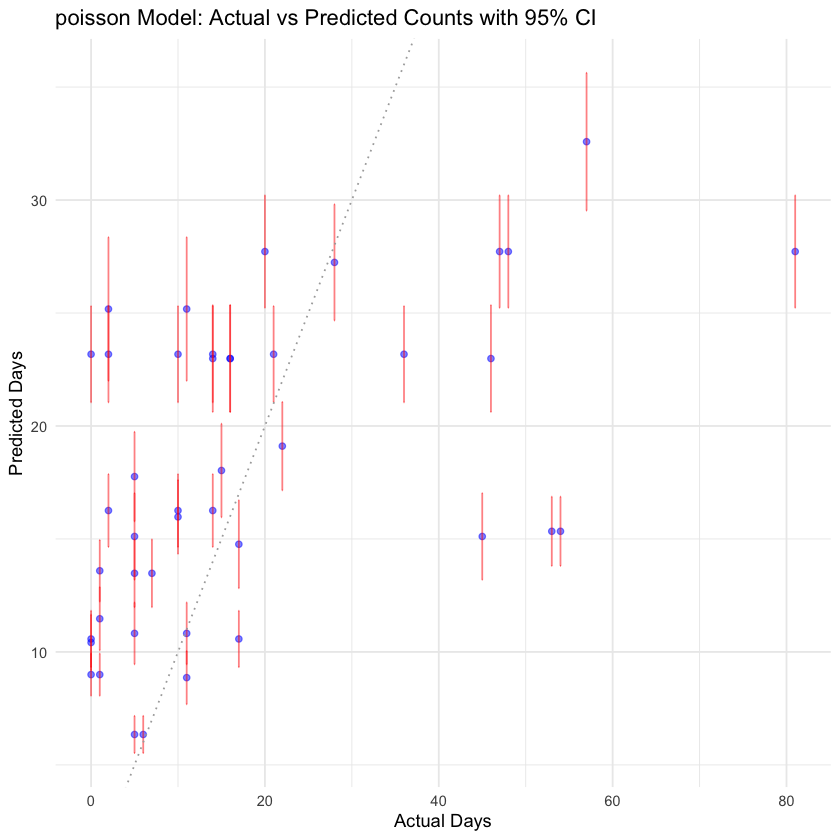

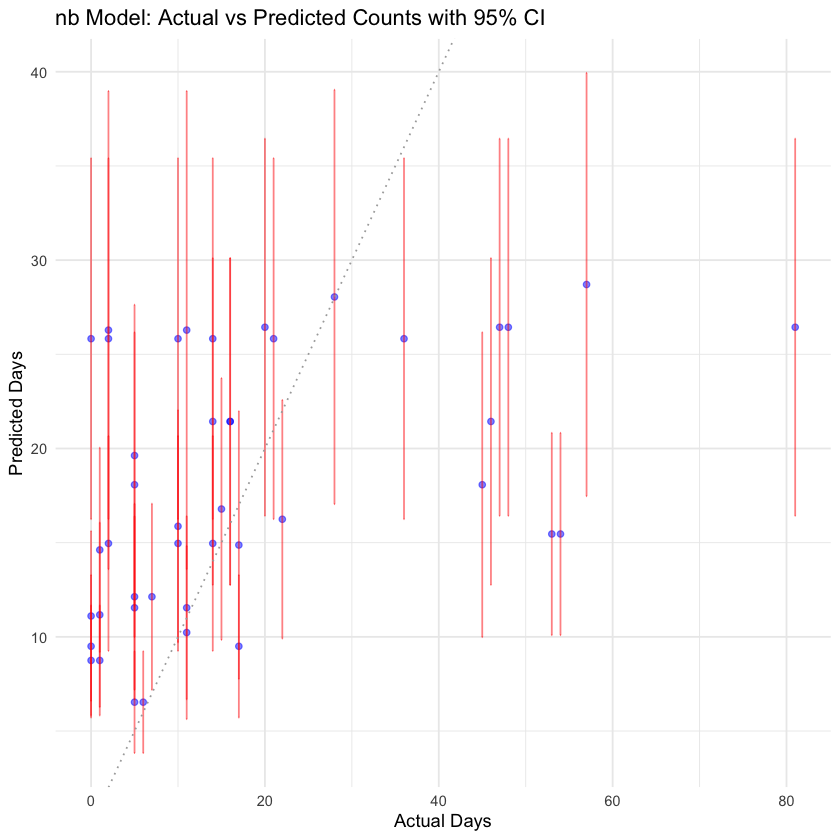

In [30]:
# Create the plots
predict_and_plot(poisson_model, test_data, "poisson")
predict_and_plot(nb_model, test_data, "nb")

# Deep Learning

In [31]:
library(reticulate)
library(keras)
use_condaenv("/Users/williamjowens/miniforge3/envs/tf-arm64", required = TRUE)
is_keras_available()

[1] TRUE

In [32]:
library(tensorflow)
use_condaenv("/Users/williamjowens/miniforge3/envs/tf-arm64", required = TRUE)
tf$constant("Hello TensorFlow from R!")


Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train




tf.Tensor(b'Hello TensorFlow from R!', shape=(), dtype=string)

## Preprocessing

In [33]:
# Split data into features and target
target <- quine$Days
features <- quine[, !(names(quine) %in% "Days")]

In [34]:
# Split data into training (60%), validation (20%), and test (20%) sets
set.seed(123) # For reproducibility
n <- nrow(features)
indices <- sample(seq_len(n))

# Calculate indices for splitting
n_train <- round(0.6 * n)
n_val <- round(0.2 * n) + n_train

# Split features
X_train <- features[indices[1:n_train], ]
X_val <- features[indices[(n_train + 1):n_val], ]
X_test <- features[indices[(n_val + 1):n], ]

# Split target
y_train <- target[indices[1:n_train]]
y_val <- target[indices[(n_train + 1):n_val]]
y_test <- target[indices[(n_val + 1):n]]

In [35]:
# Function to apply one-hot encoding
one_hot_encode <- function(data_frame) {
  dummies <- dummyVars("~ .", data = data_frame)
  encoded_data <- predict(dummies, newdata = data_frame)
  return(as.data.frame(encoded_data))
}

# Apply one-hot encoding to each set
X_train <- one_hot_encode(X_train)
X_val <- one_hot_encode(X_val)
X_test <- one_hot_encode(X_test)

## Modeling

In [36]:
# Function to plot model training history
plot_training_history <- function(history) {
  # Convert history to a data frame
  metrics_df <- as.data.frame(history$metrics)
  metrics_df$epoch <- seq_len(nrow(metrics_df))
  
  # Melting data frame for ggplot
  metrics_long <- reshape2::melt(metrics_df, id.vars = "epoch")
  
  # Separate plots for Loss and MAE
  plots <- list()
  
  # Filter for loss metrics
  loss_data <- subset(metrics_long, grepl("loss", variable))
  plots[["loss"]] <- ggplot(loss_data, aes(x = epoch, y = value, color = variable)) +
    geom_line() +
    geom_point() +
    scale_color_brewer(palette = "Set1") +
    theme_minimal() +
    labs(title = "Training and Validation Loss", x = "Epoch", y = "Loss", color = "Metric")
  
  # Filter for mean absolute error metrics
  mae_data <- subset(metrics_long, grepl("mae|mean_absolute_error", variable, ignore.case = TRUE))
  plots[["mae"]] <- ggplot(mae_data, aes(x = epoch, y = value, color = variable)) +
    geom_line() +
    geom_point() +
    scale_color_brewer(palette = "Set1") +
    theme_minimal() +
    labs(title = "Training and Validation MAE", x = "Epoch", y = "Mean Absolute Error", color = "Metric")
  
  # Return list of plots
  return(plots)
}

In [37]:
# Define the model
model_poisson <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = 'relu', input_shape = ncol(X_train)) %>%
  layer_dense(units = 16, activation = 'relu') %>%
  layer_dense(units = 1, activation = 'exponential')

# Compile the model
model_poisson %>% compile(
  loss = 'poisson',
  optimizer = 'adam',
  metrics = c('mean_absolute_error')
)

# Fit the model
history_poisson <- model_poisson %>% fit(
  x = as.matrix(X_train),
  y = y_train,
  epochs = 100,
  batch_size = 10,
  validation_data = list(as.matrix(X_val), y_val)
)

$loss

$mae


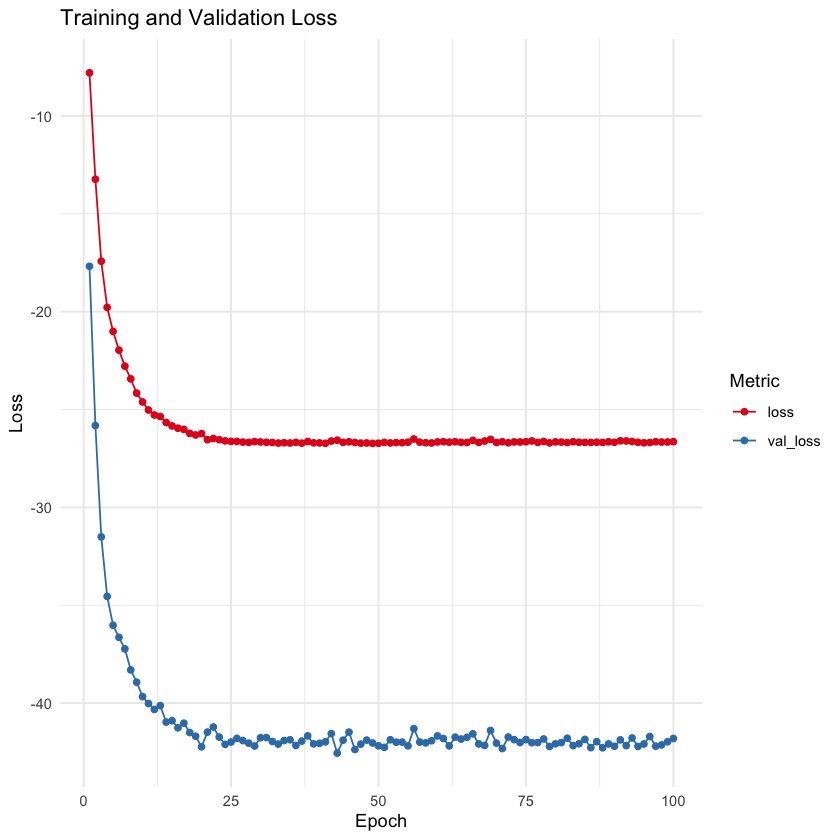

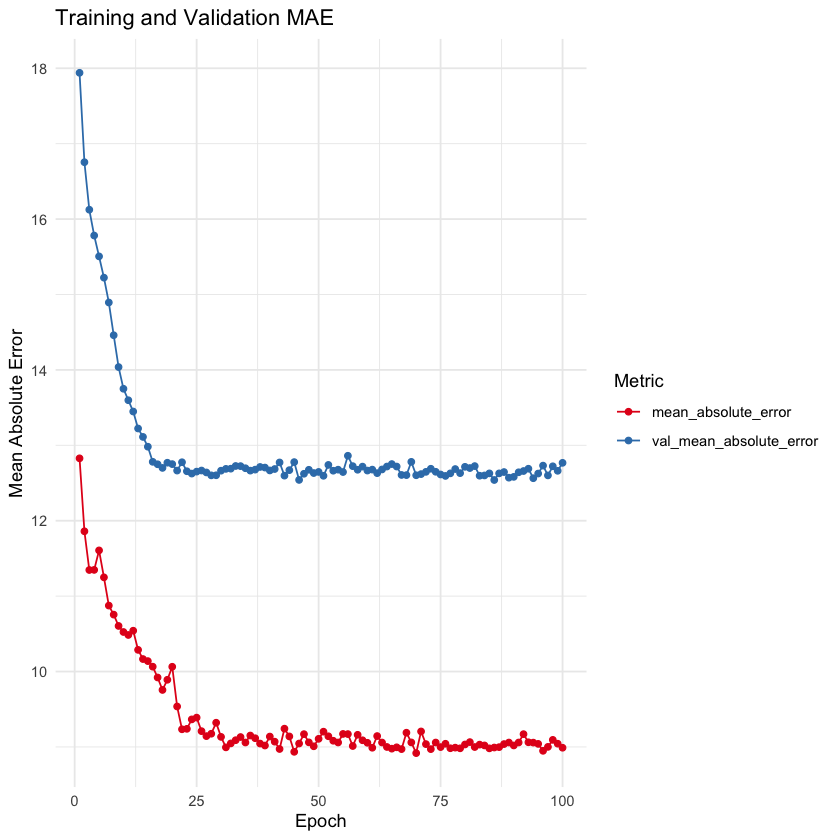

In [38]:
# Visualize the training history
plot_training_history(history_poisson)

In [39]:
# Negative binomial loss function
negative_binomial_loss <- function(y_true, y_pred) {
  theta <- k_constant(1.0, dtype = "float32")  # Dispersion parameter, ensure float32 type
  y_true_float <- k_cast(y_true, "float32")    # Cast y_true to float32
  y_pred_float <- k_cast(y_pred, "float32")    # Cast y_pred to float32

  # Add clipping for stability
  epsilon <- k_epsilon()
  y_pred_float_clipped <- k_clip(y_pred_float, epsilon, 1e6)  # Clip predictions to avoid Inf or -Inf in logs

  t1 <- y_true_float * k_log(y_pred_float_clipped / (theta + y_pred_float_clipped))
  t2 <- theta * k_log(theta / (theta + y_pred_float_clipped))
  return(-k_mean(t1 + t2))
}

In [40]:
# Define the model
model_nb <- keras_model_sequential() %>%
  layer_dense(units = 32, activation = 'relu', input_shape = ncol(X_train)) %>%
  layer_dense(units = 16, activation = 'relu') %>%
  layer_dense(units = 1, activation = 'exponential')

# Compile the model
model_nb %>% compile(
  loss = negative_binomial_loss,
  optimizer = 'adam',
  metrics = c('mean_absolute_error')
)

# Fit the model
history_nb <- model_nb %>% fit(
  x = as.matrix(X_train),
  y = y_train,
  epochs = 100,
  batch_size = 10,
  validation_data = list(as.matrix(X_val), y_val)
)

$loss

$mae


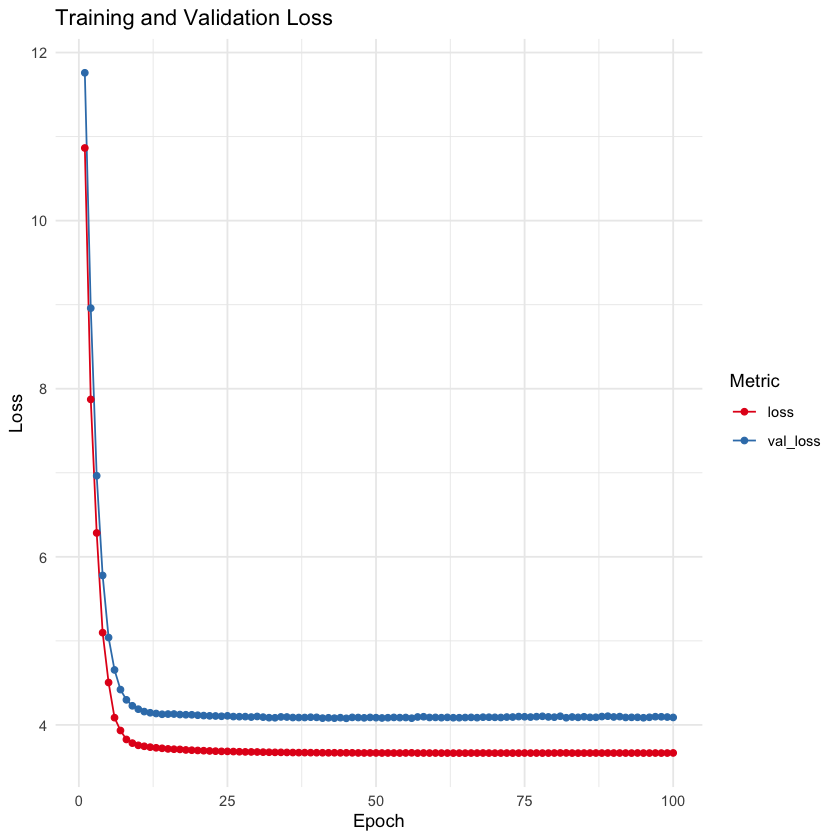

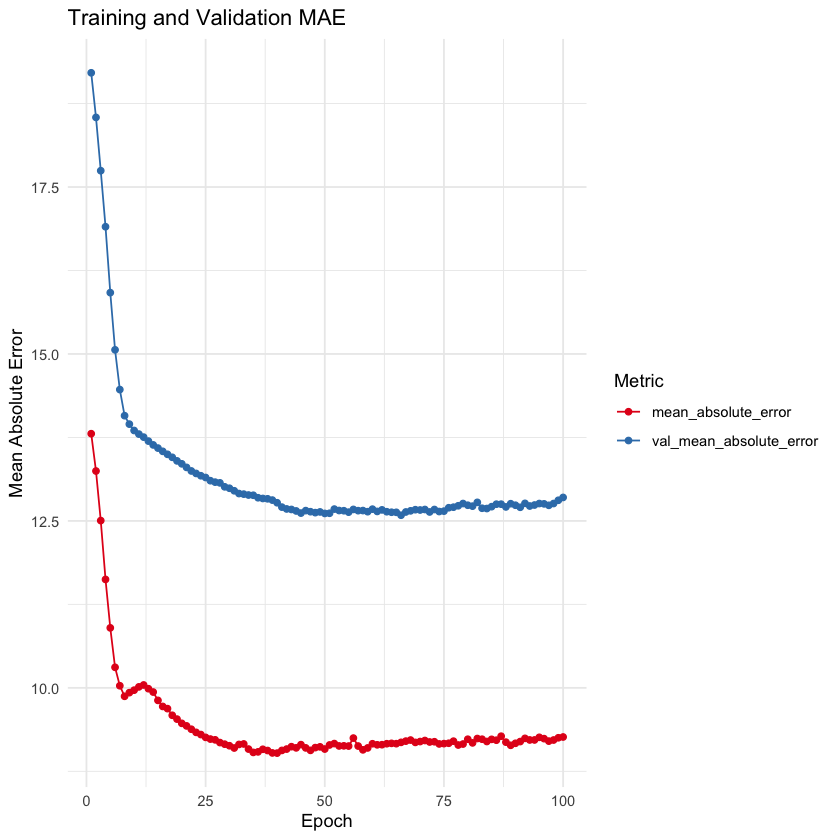

In [41]:
# Visualize the training history
plot_training_history(history_nb)

## Hyperparameter Tuning

In [42]:
library(rBayesianOptimization)

In [43]:
# Define activation and optimizer choices
activation_options <- c('relu', 'tanh', 'gelu')
optimizer_options <- c('adam', 'rmsprop')

In [44]:
# Define training and evaluation function
train_evaluate_poisson <- function(units_layer_1, units_layer_2, dropout_rate, lr, activation_index, optimizer_index) {
  # Select from the options using the index
  activation_selected <- activation_options[activation_index]
  optimizer_selected <- optimizer_options[optimizer_index]

  model <- keras_model_sequential() %>%
    layer_dense(units = as.integer(units_layer_1), activation = activation_selected, input_shape = ncol(X_train)) %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = as.integer(units_layer_2), activation = activation_selected) %>%
    layer_dense(units = 1, activation = 'exponential')
      
  # Use the selected optimizer
  optimizer <- switch(optimizer_selected,
                      adam = optimizer_adam(lr = lr, clipnorm = 1.0),
                      rmsprop = optimizer_rmsprop(lr = lr, clipnorm = 1.0))
    
  model %>% compile(
    optimizer = optimizer,
    loss = 'poisson',
    metrics = c('mean_absolute_error')
  )
    
  history <- model %>% fit(
    x = as.matrix(X_train),
    y = y_train,
    epochs = 100,
    batch_size = 10,
    validation_data = list(as.matrix(X_val), y_val),
    verbose = 0
  )
    
  val_loss <- min(history$metrics$val_loss)
  return(list(Score = -val_loss, Pred = val_loss))
}

In [45]:
# Define the search space
bounds_poisson <- list(
  units_layer_1 = c(16L, 128L),
  units_layer_2 = c(16L, 128L),
  dropout_rate = c(0.1, 0.5),
  lr = c(0.001, 0.01),
  activation_index = c(1L, length(activation_options)),
  optimizer_index = c(1L, length(optimizer_options))
)

In [46]:
# Run the Bayesian optimization
set.seed(123)
bayes_opt_poisson <- BayesianOptimization(
  FUN = train_evaluate_poisson,
  bounds = bounds_poisson,
  init_points = 20,
  n_iter = 20,
  acq = "ei",
  verbose = TRUE
)

elapsed = 10.631	Round = 1	units_layer_1 = 48.0000	units_layer_2 = 116.0000	dropout_rate = 0.15712	lr = 0.006986037	activation_index = 1.0000	optimizer_index = 2.0000	Value = 41.84051 
elapsed = 9.33	Round = 2	units_layer_1 = 104.0000	units_layer_2 = 94.0000	dropout_rate = 0.2658185	lr = 0.001853566	activation_index = 2.0000	optimizer_index = 1.0000	Value = 42.98867 
elapsed = 9.783	Round = 3	units_layer_1 = 62.0000	units_layer_2 = 88.0000	dropout_rate = 0.2654897	lr = 0.004455727	activation_index = 2.0000	optimizer_index = 1.0000	Value = 42.72798 
elapsed = 12.585	Round = 4	units_layer_1 = 115.0000	units_layer_2 = 127.0000	dropout_rate = 0.2475382	lr = 0.003469453	activation_index = 3.0000	optimizer_index = 2.0000	Value = 42.59628 
elapsed = 10.39	Round = 5	units_layer_1 = 121.0000	units_layer_2 = 89.0000	dropout_rate = 0.1609779	lr = 0.00833176	activation_index = 1.0000	optimizer_index = 1.0000	Value = 42.98973 
elapsed = 10.827	Round = 6	units_layer_1 = 21.0000	units_layer_2 = 95.00

In [47]:
# Print the best hyperparameters
best_params_poisson <- bayes_opt_poisson$Best_Par

activation_index_poisson <- as.integer(best_params_poisson["activation_index"])
optimizer_index_poisson <- as.integer(best_params_poisson["optimizer_index"])

best_activation_poisson <- activation_options[activation_index_poisson]
best_optimizer_poisson <- optimizer_options[optimizer_index_poisson]

print(best_params_poisson)
print(paste("Best activation function:", best_activation_poisson))
print(paste("Best optimizer:", best_optimizer_poisson))

   units_layer_1    units_layer_2     dropout_rate               lr 
    7.500000e+01     1.040000e+02     4.226870e-01     2.831378e-03 
activation_index  optimizer_index 
    2.000000e+00     1.000000e+00 
[1] "Best activation function: tanh"
[1] "Best optimizer: adam"


In [48]:
# Define training and evaluation function
train_evaluate_nb <- function(units_layer_1, units_layer_2, dropout_rate, lr, activation_index, optimizer_index) {
  # Select from the options using the index
  activation_selected <- activation_options[activation_index]
  optimizer_selected <- optimizer_options[optimizer_index]

  model <- keras_model_sequential() %>%
    layer_dense(units = as.integer(units_layer_1), activation = activation_selected, input_shape = ncol(X_train)) %>%
    layer_dropout(rate = dropout_rate) %>%
    layer_dense(units = as.integer(units_layer_2), activation = activation_selected) %>%
    layer_dense(units = 1, activation = 'softplus') # Ensure positive output for the Negative Binomial model
  
  # Use the selected optimizer
  optimizer <- switch(optimizer_selected,
                      adam = optimizer_adam(lr = lr, clipnorm = 1.0),
                      rmsprop = optimizer_rmsprop(lr = lr, clipnorm = 1.0))
  
  model %>% compile(
    optimizer = optimizer,
    loss = negative_binomial_loss,
    metrics = c('mean_absolute_error')
  )
  
  history <- model %>% fit(
    x = as.matrix(X_train),
    y = y_train,
    epochs = 100,
    batch_size = 10,
    validation_data = list(as.matrix(X_val), y_val),
    verbose = 0
  )
  
  val_loss <- min(history$metrics$val_loss)
  return(list(Score = -val_loss, Pred = val_loss))
}

In [51]:
# Safe wrapper for train_evaluate_nb to catch errors and return a large number
train_evaluate_nb_safe <- function(...) {
  tryCatch({
    train_evaluate_nb(...)
  }, error = function(e) {
    # If an error occurs, return a list with large Score and Pred values
    return(list(Score = 1e6, Pred = 1e6))
  })
}

In [52]:
# Define the search space
bounds_nb <- list(
  units_layer_1 = c(16L, 128L),
  units_layer_2 = c(16L, 128L),
  dropout_rate = c(0.1, 0.5),
  lr = c(0.001, 0.01),
  activation_index = c(1L, length(activation_options)),
  optimizer_index = c(1L, length(optimizer_options))
)

In [53]:
# Run the Bayesian optimization
set.seed(123)
bayes_opt_nb <- BayesianOptimization(
  FUN = train_evaluate_nb_safe,
  bounds = bounds_nb,
  init_points = 20,
  n_iter = 20,
  acq = "ei",
  verbose = TRUE
)

elapsed = 14.633	Round = 1	units_layer_1 = 48.0000	units_layer_2 = 116.0000	dropout_rate = 0.15712	lr = 0.006986037	activation_index = 1.0000	optimizer_index = 2.0000	Value = -4.107258 
elapsed = 12.826	Round = 2	units_layer_1 = 104.0000	units_layer_2 = 94.0000	dropout_rate = 0.2658185	lr = 0.001853566	activation_index = 2.0000	optimizer_index = 1.0000	Value = -4.094495 
elapsed = 17.207	Round = 3	units_layer_1 = 62.0000	units_layer_2 = 88.0000	dropout_rate = 0.2654897	lr = 0.004455727	activation_index = 2.0000	optimizer_index = 1.0000	Value = -4.097464 
elapsed = 16.814	Round = 4	units_layer_1 = 115.0000	units_layer_2 = 127.0000	dropout_rate = 0.2475382	lr = 0.003469453	activation_index = 3.0000	optimizer_index = 2.0000	Value = -4.092861 
elapsed = 13.276	Round = 5	units_layer_1 = 121.0000	units_layer_2 = 89.0000	dropout_rate = 0.1609779	lr = 0.00833176	activation_index = 1.0000	optimizer_index = 1.0000	Value = -4.101177 
elapsed = 14.928	Round = 6	units_layer_1 = 21.0000	units_layer_

In [54]:
# Print the best hyperparameters
best_params_nb <- bayes_opt_nb$Best_Par

activation_index_nb <- as.integer(best_params_nb["activation_index"])
optimizer_index_nb <- as.integer(best_params_nb["optimizer_index"])

best_activation_nb <- activation_options[activation_index_nb]
best_optimizer_nb <- optimizer_options[optimizer_index_nb]

print(best_params_nb)
print(paste("Best activation function:", best_activation_nb))
print(paste("Best optimizer:", best_optimizer_nb))

   units_layer_1    units_layer_2     dropout_rate               lr 
    16.000000000     41.000000000      0.306108623      0.002715758 
activation_index  optimizer_index 
     3.000000000      1.000000000 
[1] "Best activation function: gelu"
[1] "Best optimizer: adam"


## Rebuilding Models

In [55]:
# Extract best hyperparameters
best_units_layer_1_poisson <- as.integer(best_params_poisson["units_layer_1"])
best_units_layer_2_poisson <- as.integer(best_params_poisson["units_layer_2"])
best_dropout_rate_poisson <- best_params_poisson["dropout_rate"]
best_lr_poisson <- best_params_poisson["lr"]

In [56]:
# Define and compile the model with the best hyperparameters
model_poisson_best <- keras_model_sequential() %>%
  layer_dense(units = best_units_layer_1_poisson, activation = best_activation_poisson, input_shape = ncol(X_train)) %>%
  layer_dropout(rate = best_dropout_rate_poisson) %>%
  layer_dense(units = best_units_layer_2_poisson, activation = best_activation_poisson) %>%
  layer_dense(units = 1, activation = 'exponential')

# Select the optimizer based on the best hyperparameter
optimizer_best_poisson <- switch(best_optimizer_poisson,
                                 "adam" = optimizer_adam(lr = best_lr_poisson, clipnorm = 1.0),
                                 "rmsprop" = optimizer_rmsprop(lr = best_lr_poisson, clipnorm = 1.0))

# Compile the model
model_poisson_best %>% compile(
  optimizer = optimizer_best_poisson,
  loss = 'poisson',
  metrics = c('mean_absolute_error')
)

# Retrain the model with the best hyperparameters
history_poisson_best <- model_poisson_best %>% fit(
  x = as.matrix(X_train),
  y = y_train,
  epochs = 100,
  batch_size = 10,
  validation_data = list(as.matrix(X_val), y_val),
  verbose = 1
)

$loss

$mae


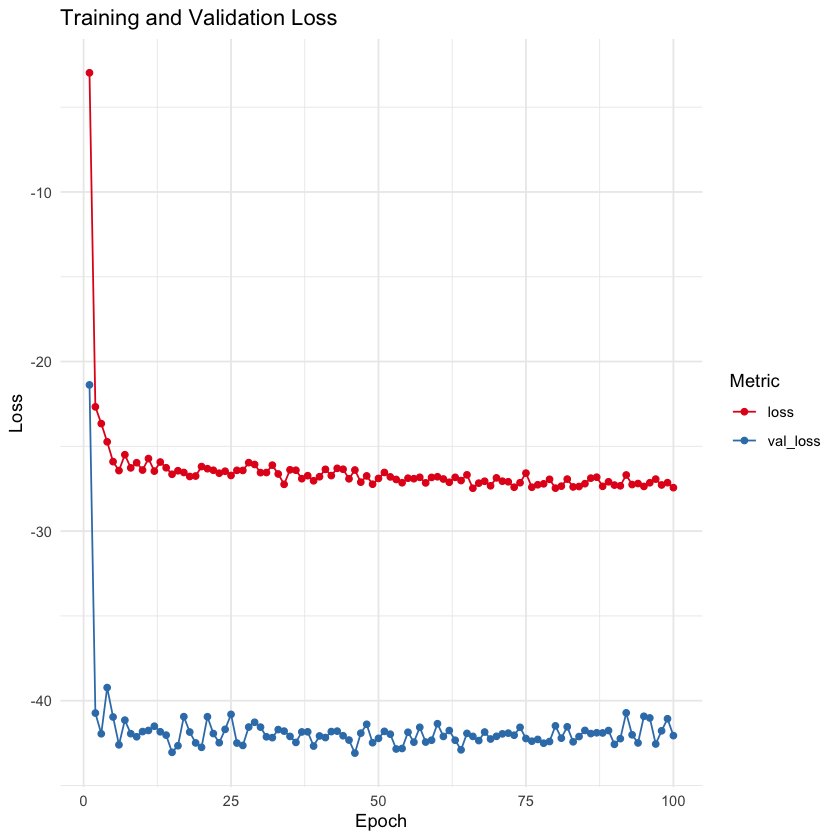

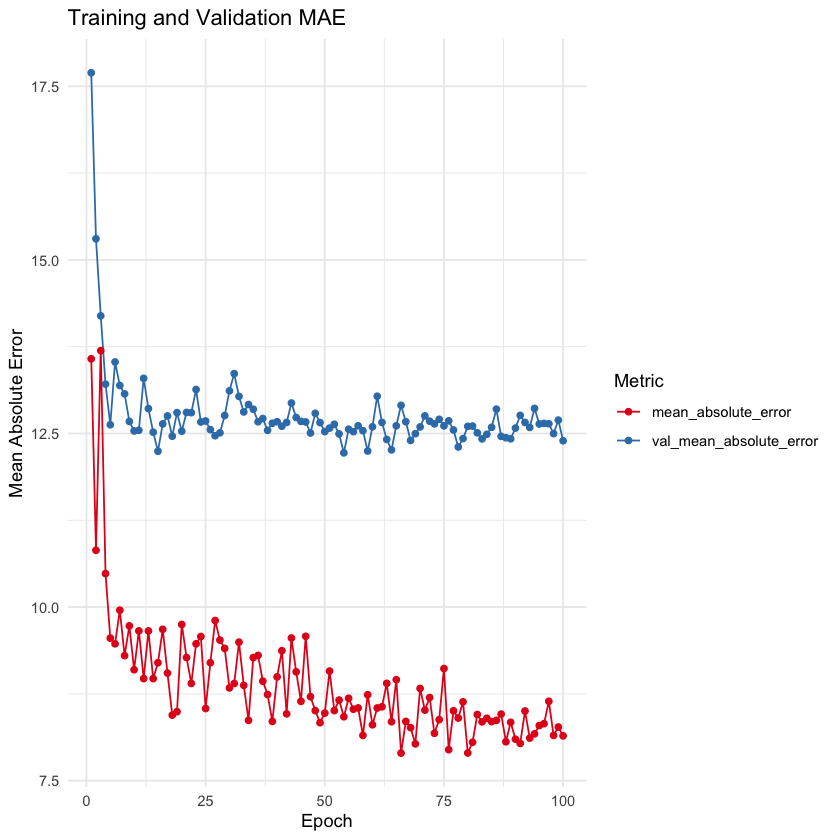

In [65]:
# Visualize the training history
plot_training_history(history_poisson_best)

In [57]:
# Extract best hyperparameters
best_units_layer_1_nb <- as.integer(best_params_nb["units_layer_1"])
best_units_layer_2_nb <- as.integer(best_params_nb["units_layer_2"])
best_dropout_rate_nb <- best_params_nb["dropout_rate"]
best_lr_nb <- best_params_nb["lr"]

In [58]:
# Define and compile the model with the best hyperparameters
model_nb_best <- keras_model_sequential() %>%
  layer_dense(units = best_units_layer_1_nb, activation = best_activation_nb, input_shape = ncol(X_train)) %>%
  layer_dropout(rate = best_dropout_rate_nb) %>%
  layer_dense(units = best_units_layer_2_nb, activation = best_activation_nb) %>%
  layer_dense(units = 1, activation = 'softplus') # Ensure positive output for the Negative Binomial model

# Select the optimizer based on the best hyperparameter
optimizer_best_nb <- switch(best_optimizer_nb,
                            "adam" = optimizer_adam(lr = best_lr_nb, clipnorm = 1.0),
                            "rmsprop" = optimizer_rmsprop(lr = best_lr_nb, clipnorm = 1.0))

# Compile the model
model_nb_best %>% compile(
  optimizer = optimizer_best_nb,
  loss = negative_binomial_loss,
  metrics = c('mean_absolute_error')
)

# Retrain the model with the best hyperparameters
history_nb_best <- model_nb_best %>% fit(
  x = as.matrix(X_train),
  y = y_train,
  epochs = 100,
  batch_size = 10,
  validation_data = list(as.matrix(X_val), y_val),
  verbose = 1
)

$loss

$mae


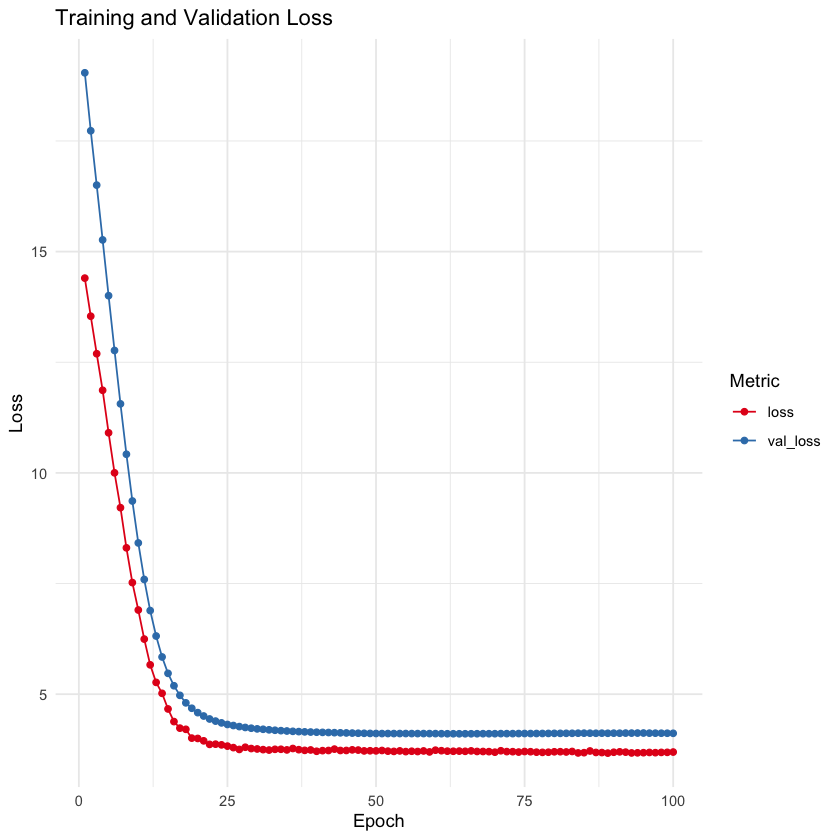

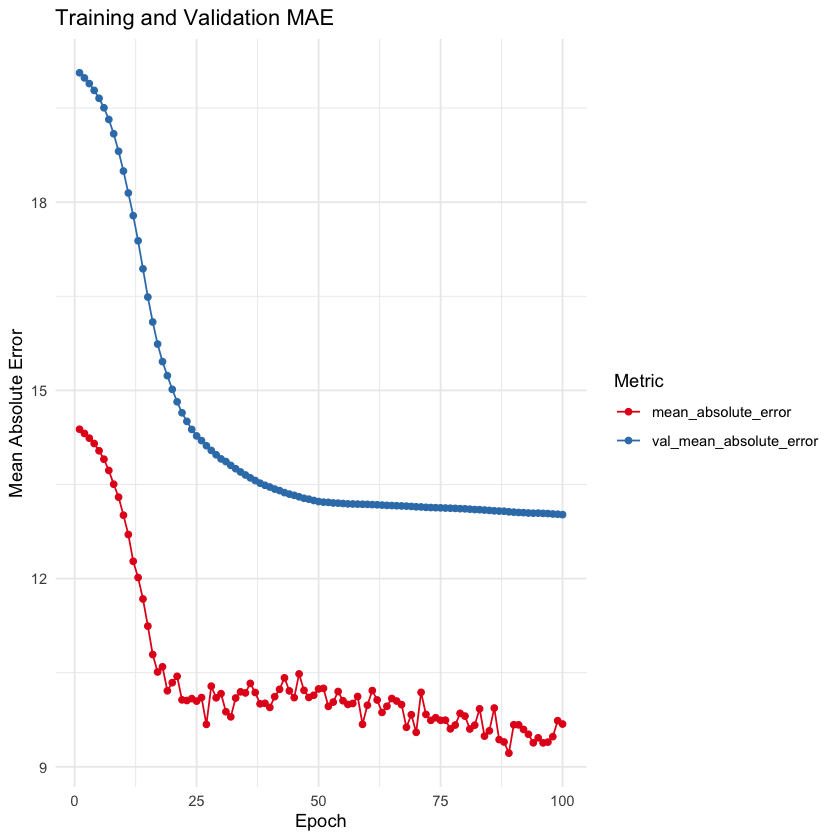

In [66]:
# Visualize the training history
plot_training_history(history_nb_best)

## Predictions

In [59]:
# Predict with the Poisson model
predictions_poisson <- predict(model_poisson_best, as.matrix(X_test))

# Predict with the negative binomial model
predictions_nb <- predict(model_nb_best, as.matrix(X_test))

In [60]:
# Calculate MAE and RMSE for the Poisson model
mae_poisson <- mean(abs(predictions_poisson - y_test))
rmse_poisson <- sqrt(mean((predictions_poisson - y_test)^2))

# Calculate MAE and RMSE for the negative binomial model
mae_nb <- mean(abs(predictions_nb - y_test))
rmse_nb <- sqrt(mean((predictions_nb - y_test)^2))

# Print the results
cat("Poisson Model MAE:", mae_poisson, "RMSE:", rmse_poisson, "\n")
cat("Negative Binomial Model MAE:", mae_nb, "RMSE:", rmse_nb, "\n")

Poisson Model MAE: 15.51748 RMSE: 21.5318 
Negative Binomial Model MAE: 14.1782 RMSE: 20.5293 


In [61]:
# Create a data frame for the metrics
model_performance <- data.frame(
  Model = c("Poisson", "Negative Binomial"),
  MAE = c(mae_poisson, mae_nb),
  RMSE = c(rmse_poisson, rmse_nb)
)

model_performance

Model,MAE,RMSE
<chr>,<dbl>,<dbl>
Poisson,15.51748,21.5318
Negative Binomial,14.17820,20.5293


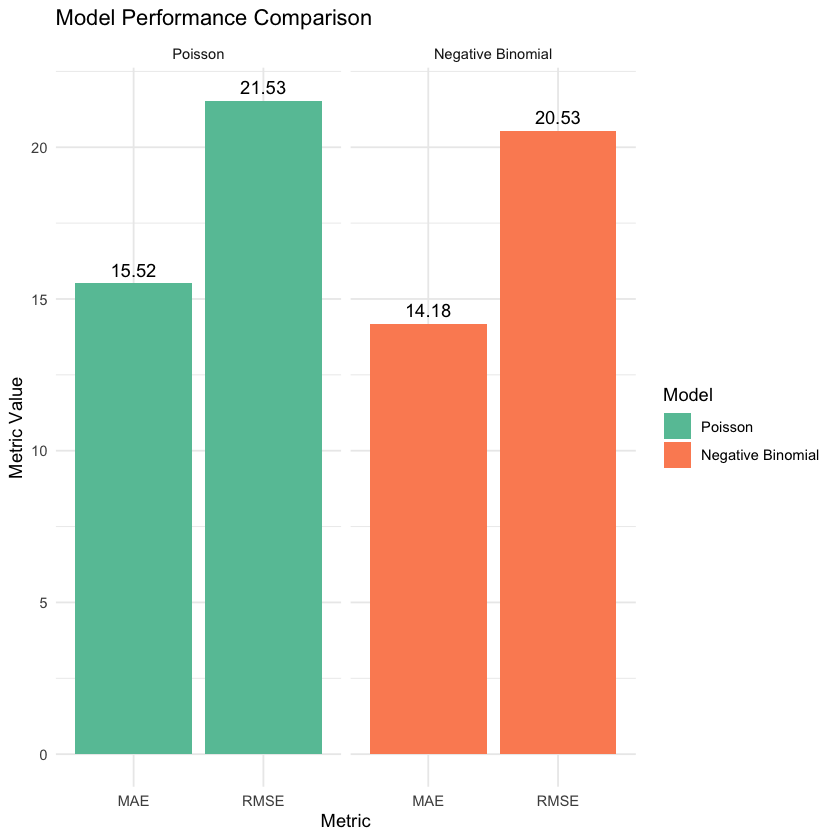

In [62]:
# Melting the data frame to long format for ggplot
library(reshape2)
model_performance_long <- melt(model_performance, id.vars = "Model")

# Adjust factor levels to control the order
model_performance_long$Model <- factor(model_performance_long$Model, levels = c("Poisson", "Negative Binomial"))

# Create bar plot
ggplot(model_performance_long, aes(x = variable, y = value, fill = Model)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_minimal() +
  labs(title = "Model Performance Comparison",
       x = "Metric",
       y = "Metric Value") +
  scale_fill_brewer(palette = "Set2", name = "Model") +
  geom_text(aes(label = round(value, 2), y = value + 0.02), position = position_dodge(width = 0.9), vjust = -0.5) +
  facet_wrap(~Model, nrow = 1)

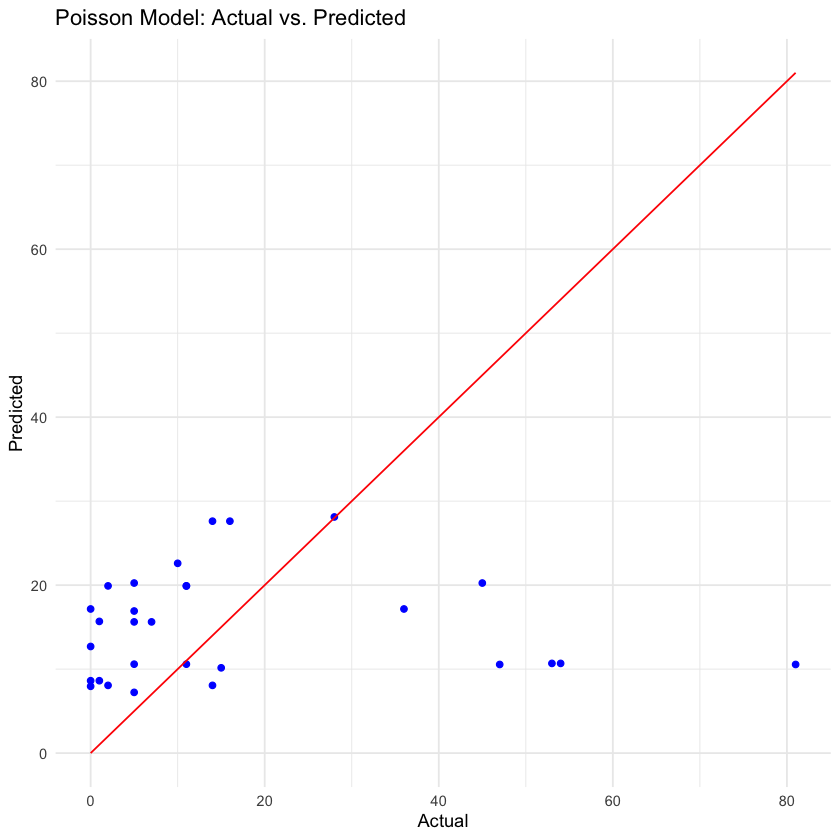

In [63]:
# Plot actual vs. predicted
ggplot() +
  geom_point(aes(x = y_test, y = predictions_poisson), colour = "blue") +
  geom_line(aes(x = y_test, y = y_test), colour = "red") +
  labs(title = "Poisson Model: Actual vs. Predicted", x = "Actual", y = "Predicted") +
  theme_minimal()

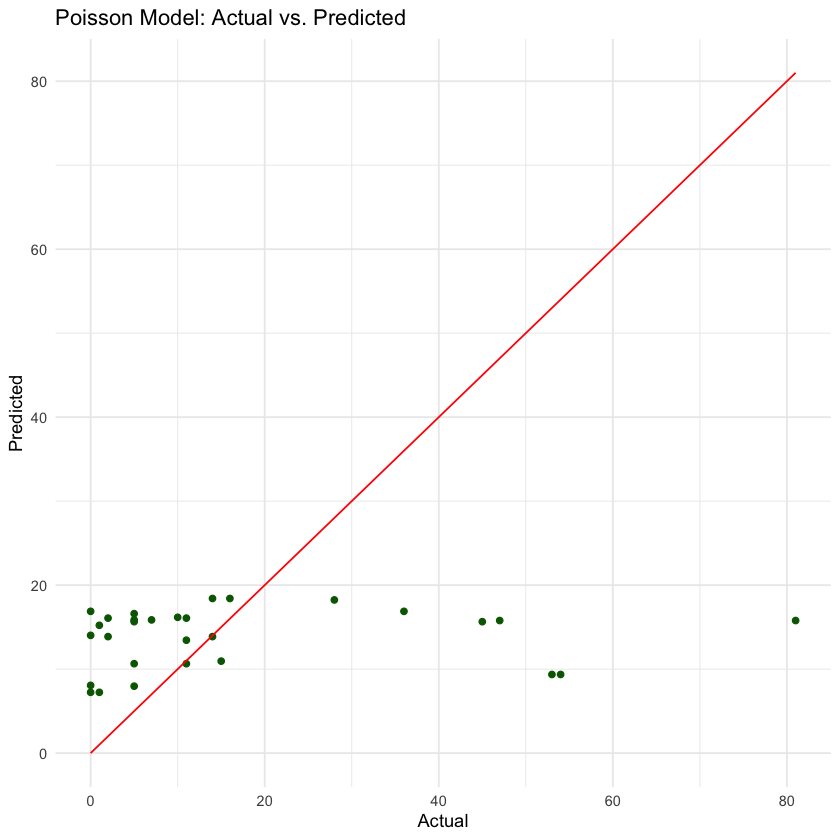

In [64]:
# Plot actual vs. predicted
ggplot() +
  geom_point(aes(x = y_test, y = predictions_nb), colour = "darkgreen") +
  geom_line(aes(x = y_test, y = y_test), colour = "red") +
  labs(title = "Poisson Model: Actual vs. Predicted", x = "Actual", y = "Predicted") +
  theme_minimal()